# Model Performance Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import json
import seaborn as sns

## Load Rollouts from json

In [2]:
rollout_path = "../assets/rollouts/"
rollout_files = glob.glob(os.path.join(rollout_path, "rollout_results_*.json"))

# Load all rollout files
results = {}
for file in rollout_files:
    with open(file, "r") as f:
        # Get the filename without the path and extension e.g "merged_task_1_lora"
        filename = os.path.basename(file)
        filename = filename.split(".")[0]
        filename = "_".join(filename.split("_")[2:])
        # Load the json file
        rollout = json.load(f)
        results[filename] = rollout

print(sorted(results.keys()))


['merged_task1_fpft', 'merged_task1_lora', 'merged_task2_fpft', 'merged_task2_lora', 'merged_task3_fpft', 'merged_task3_lora', 'merged_task4_fpft', 'merged_task4_lora', 'task1_60k_fpft', 'task1_60k_lora', 'task1_fpft', 'task1_lora', 'task2_60k_fpft', 'task2_60k_lora', 'task2_fpft', 'task2_lora', 'task3_60k_fpft', 'task3_60k_lora', 'task3_fpft', 'task3_lora', 'task4_60k_fpft', 'task4_60k_lora', 'task4_fpft', 'task4_lora']


## Turn into pd.DataFrame

In [3]:
rollout = results["merged_task2_lora"]

df = pd.DataFrame(rollout)
print(df.shape)
df.head()


(20, 6)


,timestamp,success,duration,steps_completed,total_steps,score
0,1.765203e+09,False,25.679944,2,4,0.5
1,1.765203e+09,False,8.374424,0,4,0.0
2,1.765203e+09,False,21.421537,2,4,0.5
3,1.765203e+09,False,19.943922,2,4,0.5
4,1.765203e+09,False,15.807475,2,4,0.5


## Calculate Scores

---

just to make sure

In [4]:
for i in range(len(df)):
    df.loc[i, "score"] = df.loc[i, "steps_completed"] / df.loc[i, "total_steps"]

df.tail()

,timestamp,success,duration,steps_completed,total_steps,score
15,1.765204e+09,False,20.820444,2,4,0.5
16,1.765204e+09,False,19.537650,2,4,0.5
17,1.765204e+09,False,26.210658,0,4,0.0
18,1.765204e+09,False,37.813264,2,4,0.5
19,1.765204e+09,True,32.153528,4,4,1.0


## Calculate Avg Success Rate

In [5]:
avg_success_rate = df["success"].mean()
print(f"Avg Success Rate: {avg_success_rate}")

Avg Success Rate: 0.2


## Calculate Avg Task Progress

In [6]:
avg_task_progress = df["score"].mean()
print(f"Avg Task Progress: {avg_task_progress}")

Avg Task Progress: 0.5375


## Combine all results into a single DataFrame

----

In [7]:
df = pd.DataFrame(columns=["merged", "task", "lora", "success_rate", "avg_task_progress"])
for filename, rollout in results.items():
    # Split filename into merged (bool), task (int), lora (bool)
    merged = "merged" in filename
    if merged:
        task = int(filename.split("_")[1][-1])
    else:
        task = int(filename.split("_")[0][-1])
    lora = "lora" in filename

    # Create a temp DataFrame from the rollout
    temp = pd.DataFrame(rollout)
    # Recalculate the score
    for i in range(len(temp)):
        temp.loc[i, "score"] = temp.loc[i, "steps_completed"] / temp.loc[i, "total_steps"]
    # Calculate the success rate
    success_rate = temp["success"].mean()
    # Calculate the avg task progress
    avg_task_progress = temp["score"].mean()
    # Add the results to the main DataFrame
    df.loc[filename] = [merged, task, lora, success_rate, avg_task_progress]

df

,merged,task,lora,success_rate,avg_task_progress
merged_task4_lora,True,4,True,0.55,0.750000
task4_fpft,False,4,False,0.70,0.866667
merged_task2_lora,True,2,True,0.20,0.537500
task2_60k_fpft,False,2,False,0.25,0.687500
merged_task4_fpft,True,4,False,0.80,0.933333
task1_lora,False,1,True,0.45,0.816667
merged_task2_fpft,True,2,False,0.15,0.562500
task1_60k_lora,False,1,True,0.20,0.733333
task3_fpft,False,3,False,0.90,0.925000
task3_60k_lora,False,3,True,0.70,0.700000


## Analyse specific Subsets

### Group by merged

In [8]:
avg_success_rate = df.groupby("merged").success_rate.mean()
print(f"Avg Success Rate for Merged Models: {avg_success_rate[True]:.2f}")
print(f"Avg Success Rate for Dedicated Models: {avg_success_rate[False]:.2f}")

avg_task_progress = df.groupby("merged").avg_task_progress.mean()
print()
print(f"Avg Task Progress for Merged Models: {avg_task_progress[True]:.2f}")
print(f"Avg Task Progress for Dedicated Models: {avg_task_progress[False]:.2f}")


Avg Success Rate for Merged Models: 0.54
Avg Success Rate for Dedicated Models: 0.56

Avg Task Progress for Merged Models: 0.75
Avg Task Progress for Dedicated Models: 0.79


### Group by LoRA

In [9]:
avg_success_rate = df.groupby("lora").success_rate.mean()
print(f"Avg Success Rate for LoRA Models: {avg_success_rate[True]:.2f}")
print(f"Avg Success Rate for Non-LoRA Models: {avg_success_rate[False]:.2f}")

avg_task_progress = df.groupby("lora").avg_task_progress.mean()
print()
print(f"Avg Task Progress for LoRA Models: {avg_task_progress[True]:.2f}")
print(f"Avg Task Progress for Non-LoRA Models: {avg_task_progress[False]:.2f}")

Avg Success Rate for LoRA Models: 0.48
Avg Success Rate for Non-LoRA Models: 0.63

Avg Task Progress for LoRA Models: 0.73
Avg Task Progress for Non-LoRA Models: 0.82


### Group by task

In [10]:
avg_success_rate = df.groupby("task").success_rate.mean()
for i in range(1, len(avg_success_rate) + 1):
    print(f"Avg Success Rate for Task {i}: {avg_success_rate[i]:.2f}")

avg_task_progress = df.groupby("task").avg_task_progress.mean()
print()
for i in range(1, len(avg_task_progress) + 1):
    print(f"Avg Task Progress for Task {i}: {avg_task_progress[i]:.2f}")


Avg Success Rate for Task 1: 0.51
Avg Success Rate for Task 2: 0.18
Avg Success Rate for Task 3: 0.83
Avg Success Rate for Task 4: 0.69

Avg Task Progress for Task 1: 0.82
Avg Task Progress for Task 2: 0.60
Avg Task Progress for Task 3: 0.84
Avg Task Progress for Task 4: 0.84


### Group by LoRA and merged

In [11]:
avg_success_rate = df.groupby(["lora", "merged"]).success_rate.mean()
print(avg_success_rate)

avg_task_progress = df.groupby(["lora", "merged"]).avg_task_progress.mean()
print()
print(avg_task_progress)


lora   merged
False  False     0.66250
       True      0.56250
True   False     0.45625
       True      0.52500
Name: success_rate, dtype: float64

lora   merged
False  False     0.843229
       True      0.773958
True   False     0.731250
       True      0.734375
Name: avg_task_progress, dtype: float64


### Group by task and merged

In [12]:
avg_success_rate = df.groupby(["task", "merged"]).success_rate.mean()
print(avg_success_rate)

avg_task_progress = df.groupby(["task", "merged"]).avg_task_progress.mean()
print()
print(avg_task_progress)

task  merged
1     False     0.5125
      True      0.5000
2     False     0.1875
      True      0.1750
3     False     0.8375
      True      0.8250
4     False     0.7000
      True      0.6750
Name: success_rate, dtype: float64

task  merged
1     False     0.837500
      True      0.800000
2     False     0.628125
      True      0.550000
3     False     0.850000
      True      0.825000
4     False     0.833333
      True      0.841667
Name: avg_task_progress, dtype: float64


## Plots

---

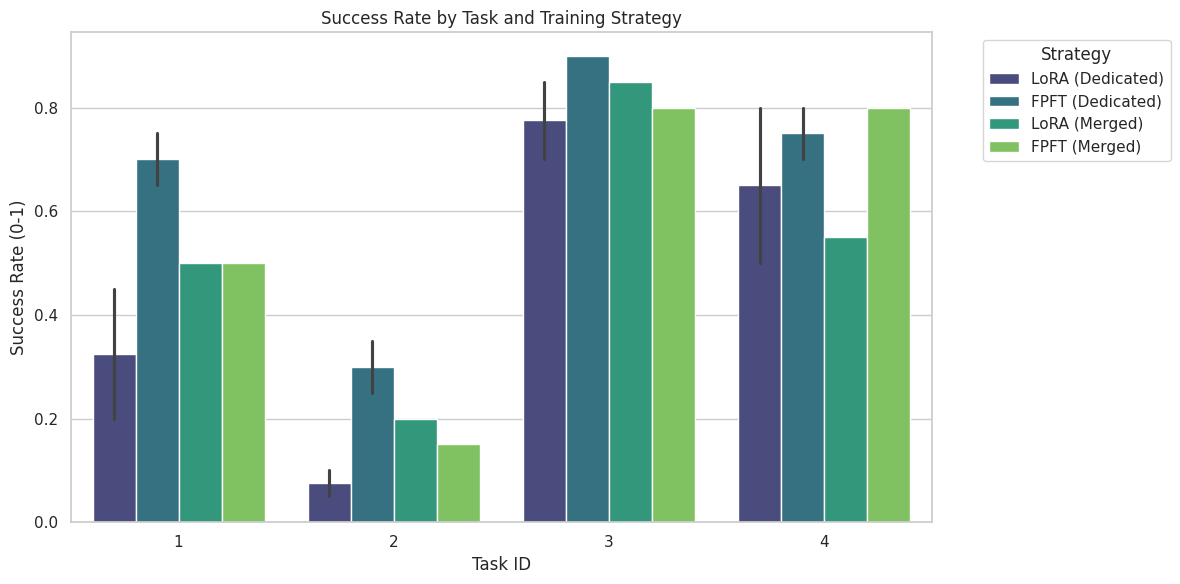

In [13]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# 1. THE MAIN COMPARISON: Success Rate per Task
# This answers: "Which model is best for which task?"
plt.figure(figsize=(12, 6))
# Create a custom 'Method' column for cleaner legends
df['Method'] = df.apply(lambda x: 
    f"{'LoRA' if x['lora'] else 'FPFT'} ({'Merged' if x['merged'] else 'Dedicated'})", axis=1)

sns.barplot(
    data=df, 
    x="task", 
    y="success_rate", 
    hue="Method",
    palette="viridis"
)
plt.title("Success Rate by Task and Training Strategy")
plt.ylabel("Success Rate (0-1)")
plt.xlabel("Task ID")
plt.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

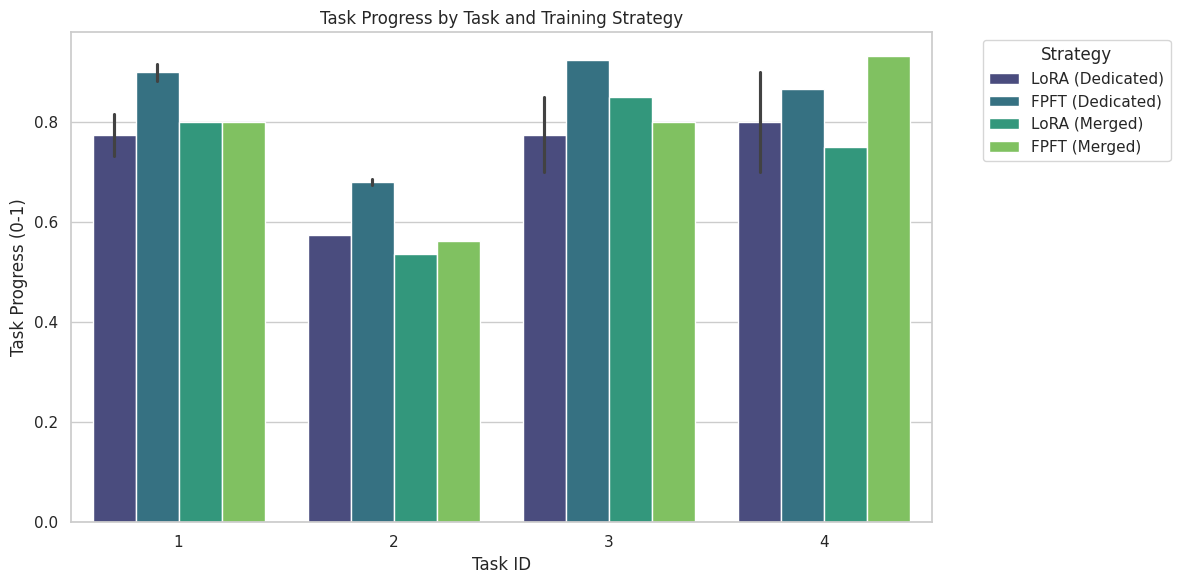

In [14]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# 1. THE MAIN COMPARISON: Success Rate per Task
# This answers: "Which model is best for which task?"
plt.figure(figsize=(12, 6))
# Create a custom 'Method' column for cleaner legends
df['Method'] = df.apply(lambda x: 
    f"{'LoRA' if x['lora'] else 'FPFT'} ({'Merged' if x['merged'] else 'Dedicated'})", axis=1)

sns.barplot(
    data=df, 
    x="task", 
    y="avg_task_progress", 
    hue="Method",
    palette="viridis"
)
plt.title("Task Progress by Task and Training Strategy")
plt.ylabel("Task Progress (0-1)")
plt.xlabel("Task ID")
plt.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

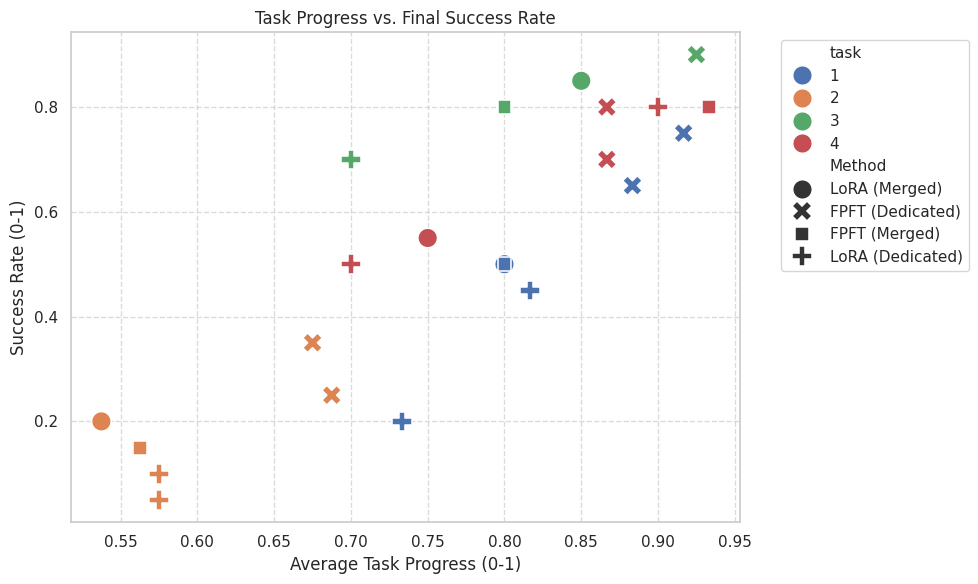

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, 
    x="avg_task_progress", 
    y="success_rate", 
    hue="task", 
    style="Method", 
    s=200, # Marker size
    palette="deep"
)
plt.title("Task Progress vs. Final Success Rate")
plt.xlabel("Average Task Progress (0-1)")
plt.ylabel("Success Rate (0-1)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

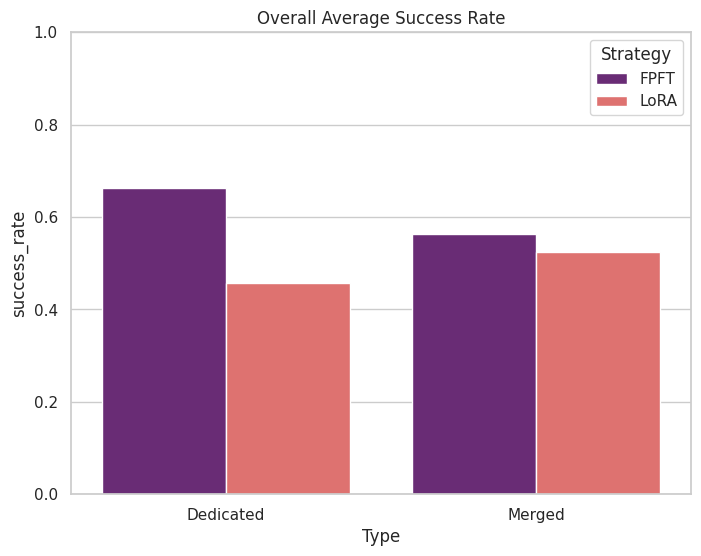

In [16]:
plt.figure(figsize=(8, 6))
# We group by the broad categories for a high-level view
summary_df = df.groupby(['lora', 'merged'])['success_rate'].mean().reset_index()
summary_df['Strategy'] = summary_df.apply(lambda x: 
    f"{'LoRA' if x['lora'] else 'FPFT'}", axis=1)
summary_df['Type'] = summary_df.apply(lambda x: 
    f"{'Merged' if x['merged'] else 'Dedicated'}", axis=1)

sns.barplot(data=summary_df, x="Type", y="success_rate", hue="Strategy", palette="magma")
plt.title("Overall Average Success Rate")
plt.ylim(0, 1.0)
plt.show()